# Predict geothermal heat flux: KNN regression

References:
* http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://github.com/amirkdv/ghf-greenland-gbrt

Ensure R17_global_test.csv and R17_global_train.csv is in the same directory as this notebook.

Install mlxtend to use SequentialFeatureSelector (pip install mlxtend).

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline
from timeit import default_timer as timer
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature
from joblib import dump, load
from scipy.interpolate import griddata

In [2]:
def find_continent(df):
    cont = []
    for r in df.itertuples():
        if (r.lat > 0)  & (r.lon < -25): # NA
            cont.append(0)
        elif (r.lat > 30)  & (75 > r.lon) & (r.lon > -25): #EU
            cont.append(1)
        else:
            cont.append(2)
    return cont

In [3]:
xi = np.linspace(-179.5, 179.5, 360)
yi = np.linspace(-60.5, -89.5, 30)
xi, yi = np.meshgrid(xi, yi)

def plt_ant_feat(z, x=xi, y=yi, fig=None, ax=None, cmap='gist_rainbow', vmin=None, vmax=None, label='', title='', kwargs_mesh={}, kwargs_cbar={}):
    if len(z.shape) == 1:
        z = z.reshape(x.shape)
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.COASTLINE, lw=1)
    mesh = ax.pcolormesh(x, y, z, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), **kwargs_mesh)
    cb = plt.colorbar(mesh, ax=ax, **kwargs_cbar)
    cb.set_label(label)
    ax.set_title(title)
    
    return

Load the data.

In [4]:
X_labels = ["thickness_upper_crust",
            "thickness_middle_crust",
            "upper_mantle_density_anomaly",
            "d_2_ridge",
            "d_2_trench",
            "d_2_trans_ridge",
            "d_2_volcano",
            "d_2_hotspot",
            "thickness_crust",
            "d_2_young_rift",
#             "lon",
#             "lat".
#             "GHF",
            "upper_mantle_vel_structure",
            "age",
            "magnetic_anomaly",
            "depth_to_moho",
            "lithos_asthenos_bdry",
            "bougeur_gravity_anomaly",
            "topography"
]

y_lable = 'GHF'

# Load data
data_train = pd.read_csv('R17_global_train.csv')
data_train['continent'] = find_continent(data_train)
train = data_train
X_train = data_train[X_labels]
y_train = data_train[y_lable]

data_test = pd.read_csv('R17_global_test.csv')
data_test['continent'] = find_continent(data_test)
test = data_test
X_test = data_test[X_labels]
y_test = data_test[y_lable]
# Scale X
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3227, 17)
y_train shape: (3227,)
X_test shape: (807, 17)
y_test shape: (807,)


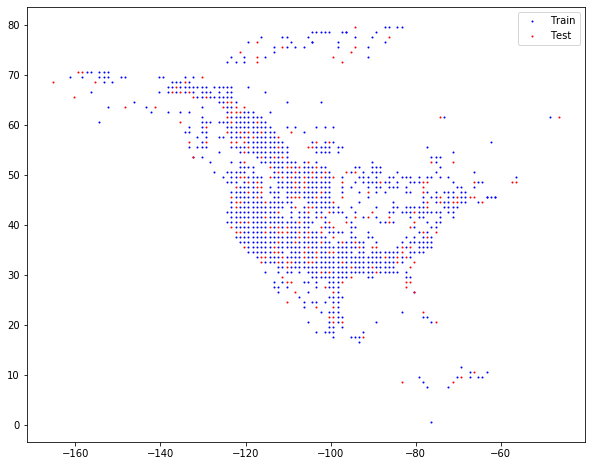

In [5]:
na_train = train[train['continent'] == 0]
na_test = test[test['continent'] == 0]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(na_train['lon'], na_train['lat'], s=1, c='b', label='Train')
ax.scatter(na_test['lon'], na_test['lat'], s=1, c='r', label='Test')
ax.legend()
plt.show()

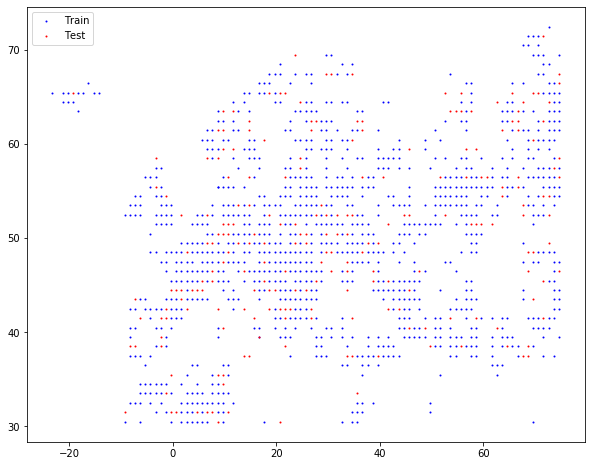

In [7]:
eu_train = train[train['continent'] == 1]
eu_test = test[test['continent'] == 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(eu_train['lon'], eu_train['lat'], s=1, c='b', label='Train')
ax.scatter(eu_test['lon'], eu_test['lat'], s=1, c='r', label='Test')
ax.legend()
plt.show()

In [8]:
eu_na_train = train[train['continent'] <= 1]
eu_na_test = test[test['continent'] <= 1]

X_eu_na_train = eu_na_train[X_labels]
y_eu_na_train = eu_na_train[y_lable]

X_eu_na_test = eu_na_test[X_labels]
y_eu_na_test = eu_na_test[y_lable]

Use sequential feature selection to decide what features to use. Grid search to determine best hyperparameter values.

In [ ]:
gkf = GroupKFold(n_splits=2)
param_grid = {'n_neighbors': range(1, 50),
   'weights': ['distance', 'uniform'],
   'metric': ['euclidean', 'manhattan', 'chebyshev']}

poss_params = ParameterGrid(param_grid)

def find_sfs(params):
    knn = KNeighborsRegressor(n_neighbors=params['n_neighbors'], metric=params['metric'], weights=params['weights'])

    sfs = SFS(estimator=knn, 
               k_features='best',
               forward=False, 
               floating=True,
#                verbose=2,
               cv=gkf)

    sfs.fit(X_eu_na_train, y_eu_na_train, groups=list(eu_na_train['continent']))
    
    return sfs

# pool = Pool()
# sfss = pool.map(find_sfs, poss_params)
# pool.close()
# pool.join()

best_score = None
best_sfs = None

for params in tqdm(poss_params):
    sfs = find_sfs(params)
    
    if best_score is None or sfs.k_score_ > best_score:
        best_score = sfs.k_score_
        best_sfs = sfs

# best_sfs = sfss[sfss.index(max(sfss, key=lambda x: x.k_score_))]


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...
STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [11]:
# print(best_score)
print(best_sfs)
print(best_sfs.k_feature_names_)
print(best_sfs.k_score_)

SequentialFeatureSelector(clone_estimator=True, cv=GroupKFold(n_splits=2),
                          estimator=KNeighborsRegressor(algorithm='auto',
                                                        leaf_size=30,
                                                        metric='manhattan',
                                                        metric_params=None,
                                                        n_jobs=None,
                                                        n_neighbors=46, p=2,
                                                        weights='uniform'),
                          floating=True, forward=False, k_features='best',
                          n_jobs=1, pre_dispatch='2*n_jobs', scoring=None,
                          verbose=0)
('thickness_upper_crust', 'thickness_middle_crust', 'upper_mantle_density_anomaly', 'd_2_volcano', 'd_2_hotspot', 'thickness_crust', 'magnetic_anomaly')
0.34667689719978523


Fit a KNN model using the best hyperparameter values.

In [12]:
best_features = best_sfs.k_feature_names_
X_eu_na_train[list(best_features)]

,thickness_upper_crust,thickness_middle_crust,upper_mantle_density_anomaly,d_2_volcano,d_2_hotspot,thickness_crust,magnetic_anomaly
0,16.004,15.0,0.0100,887.95,14.916434,41.000000,-179.996002
2,12.501,13.5,0.0092,530.13,13.729530,43.490002,7.093870
3,10.002,10.0,0.0102,2366.71,18.668155,39.509998,-31.162001
4,14.998,16.0,0.0054,1487.38,18.721645,42.299999,-29.018200
5,16.000,17.0,0.0192,2036.97,21.505813,46.459999,382.250000
...,...,...,...,...,...,...,...
3221,16.003,16.0,-0.0035,1153.54,7.516648,39.009998,65.203201
3222,9.999,11.0,-0.0330,1342.86,9.617692,34.630001,-164.878998
3223,7.000,8.0,0.0157,1204.37,10.977249,40.889999,-200.026001
3225,15.501,16.0,0.0059,1404.25,14.159802,40.130001,458.226990


In [11]:
dump(best_sfs, 'best_sfs.joblib')

['best_sfs.joblib']

In [10]:
best_sfs = load('best_sfs.joblib')

In [13]:
# Create subsets of train/test data using best features from SFS
knn = best_sfs.estimator
best_features = best_sfs.k_feature_names_
X_train_selected = X_eu_na_train[list(best_features)]
X_test_selected = X_eu_na_test[list(best_features)]

print(knn)
knn.fit(X_train_selected, y_eu_na_train)
print('R^2:', knn.score(X_test_selected, y_eu_na_test))
pred = knn.predict(X_test_selected)
rmse = (1 / np.average(y_eu_na_test)) * math.sqrt(np.average((y_eu_na_test - pred)**2))
print ('RMSE:', rmse)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=46, p=2,
                    weights='uniform')
R^2: 0.4669797417024025
RMSE: 0.21390988996624427


In [14]:
ant_data = pd.read_csv('ant_features.csv')
X_ant = ant_data[list(best_features)]

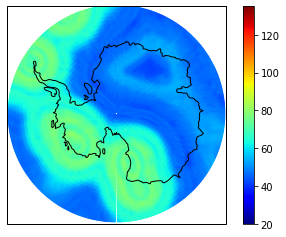

In [15]:
pred_ant = knn.predict(X_ant)
plt_ant_feat(pred_ant, vmin=20, vmax=135, cmap='jet', kwargs_mesh={'shading':'gouraud', 'aa':True})

In [23]:
pred_ant

array([54.41658052, 52.27051981, 49.30804999, ..., 44.14043881,
       44.14043881, 44.14043881])

In [28]:
xi_l = xi.reshape(pred_ant.shape)
yi_l = yi.reshape(pred_ant.shape)
pred_points = np.column_stack((xi_l, yi_l))
xv = np.linspace(-180, 180-np.finfo(float).eps, 500)
yv = np.linspace(-60, -90, 500)
xv, yv = np.meshgrid(xv, yv)
grid_int = griddata(pred_points, pred_ant, (xv, yv), method='cubic')

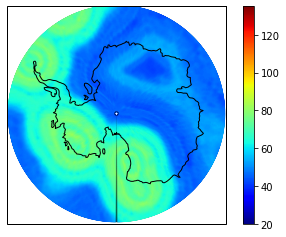

In [48]:
plt_ant_feat(grid_int.flatten(), x=xv, y=yv, vmin=20, vmax=135, cmap='jet', kwargs_mesh={'shading':'gouraud', 'aa':True})

C:\ProgramData\Anaconda3\envs\csci5622\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


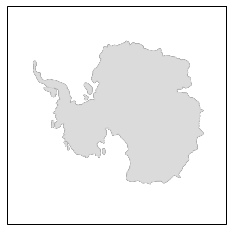

In [84]:
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE, lw=1)
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])

In [82]:
a= list(cartopy.feature.COASTLINE.geometries())[5]

In [34]:
import cartopy.io.shapereader as shpreader
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='physical',
                                      name='antarctic_ice_shelves_lines')

In [87]:
shpfilename

'C:\\Users\\Kyle Goodrick\\AppData\\Roaming\\SPB_Data\\.local\\share\\cartopy\\shapefiles\\natural_earth\\physical\\ne_10m_antarctic_ice_shelves_lines.shp'

In [35]:
reader = shpreader.Reader(shpfilename)

In [89]:
reader.geometries()

<IPython.core.display.Javascript object>


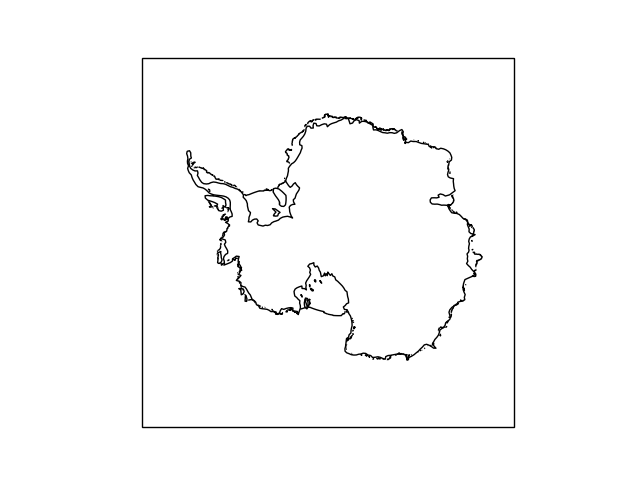

In [206]:
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
# for geo in reader.geometries():
ax.add_geometries(list(reader.geometries()), ccrs.PlateCarree(), facecolor='none', edgecolor='black')
ax.add_feature(cartopy.feature.COASTLINE, lw=1)

In [95]:
type(cartopy.feature.COASTLINE)

cartopy.feature.NaturalEarthFeature

In [120]:
type(list(reader.geometries())[0])

shapely.geometry.multilinestring.MultiLineString

In [102]:
a = list(reader.records())[0]

In [129]:
a.bounds

(56.644119093660606, -66.86041472764771, 56.80783003116136, -66.71324024848047)

In [127]:
from shapely import geometry

In [130]:
a[0]

TypeError: 'Record' object is not subscriptable

In [131]:
a

<Record: <shapely.geometry.multilinestring.MultiLineString object at 0x000001A702BFDC08>, {'scalerank': 0, 'featurecla': 'Antarctic Ice Shelf Edge', 'min_zoom': 0.0}, <fields>>

In [139]:
t = a.geometry[0].coords

In [142]:
x, y = t.xy

In [143]:
x

array('d', [56.68866417829628, 56.676055128816984, 56.644119093660606, 56.682876417879584, 56.76907270694238, 56.80783003116136, 56.800905389234174, 56.7825085793383])

In [144]:
y

array('d', [-66.86041472764771, -66.84444671006958, -66.79633595160578, -66.78315846137141, -66.76822397243905, -66.74620981228264, -66.74155893337638, -66.71324024848047])

In [36]:
ice_x = np.array([])
ice_y = np.array([])
for record in reader.records():
    for geometry in record.geometry:
        (x,y) = geometry.xy
        ice_x = np.append(ice_x, x)
        ice_y = np.append(ice_y, y)

In [158]:
record = list(reader.records())[0]
geometry = record.geometry[0]
(x, y) = geometry.coords.xy

In [167]:
(x, y) = geometry.coords.xy

In [168]:
ice_x.append(x)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [37]:
from shapely.geometry.polygon import LinearRing
from shapely.geometry.polygon import Polygon

In [38]:
ring_pts = np.array(list(zip(ice_x,ice_y)))

In [39]:
ring = LinearRing(ring_pts)
cart_ring = cartopy.feature.ShapelyFeature([ring], ccrs.PlateCarree())

In [42]:
poly = Polygon(ring_pts).convex_hull
cart_poly = cartopy.feature.ShapelyFeature([poly], ccrs.PlateCarree())

<IPython.core.display.Javascript object>


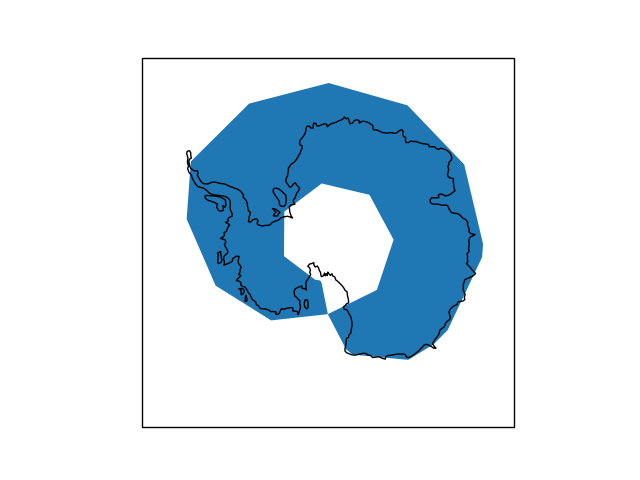

In [45]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.add_feature(cart_poly)
ax.add_feature(cartopy.feature.COASTLINE, lw=1)

In [199]:
cart_ring = cartopy.feature.ShapelyFeature([ring], ccrs.PlateCarree())

In [47]:
%matplotlib inline

In [30]:
cartopy.feature.COASTLINE

In [ ]:
cartopy.